In [3]:
#VISUALITZACIÓ D'IMATGES
import skimage.transform
def visualizeN(imagesList, nRows, nColumns, grayScale=True, titles=[],figSize=None):
    hasTitles = len(titles) >= len(imagesList)
    if figSize is None:
        figSize=(2*nColumns+5, 2*nRows+5)
    fig=plt.figure(figsize=figSize)
    for i in range (1,len(imagesList)+1):
            fig.add_subplot(nRows,nColumns,i)
            if grayScale:
                plt.imshow(imagesList[i-1], cmap='gray')
            else:
                plt.imshow(imagesList[i-1])
            if hasTitles:
                plt.title(titles[i-1])
            plt.xticks([])
            plt.yticks([])
    plt.show()

def vis1(image,figSize=(20,20)):
    visualizeN([image],1,1,figSize=figSize)

In [4]:
#CÀRREGA D'IMATGES
from skimage import io
from skimage import img_as_float
import glob
from matplotlib import pyplot as plt

def sortPaths(paths,route):

    return sorted(paths)
    filenames = [path[len(route):] for path in paths]
    filenames.sort(key= lambda s: int(s[:s.index('_')]))
    paths = [route+filename for filename in filenames]
    return paths

def cargarImages(path,first=0,step=1,last=-1):
  paths = glob.glob(path+'*.tiff')
  #Ens serveix per carregar les imatges en ordre.
  if last == -1:
    last = len(paths)
  #paths.sort(key=lambda s: s[len(path):])
  paths = sortPaths(paths,path)
  images = []
  for i in range(first,last,step):
    im = img_as_float(io.imread(paths[i],plugin='tifffile'))
    #im = cv.cvtColor(im, cv.COLOR_RGB2GRAY)
    images.append(im)
  #images = io.ImageCollection(path+"*.tiff")

  return images

def cropBorder(image, bh, bw):
    h, w = image.shape
    return image[bh:h-bh, bw:w-bw]

#PREPROCESSAT
def visOrderedImages(totalImages, vis=True):

    holos = []
    for i in range(len(totalImages[0])):
        holos.append((totalImages[1][i] - totalImages[0][i]) / totalImages[0][i])
        if(vis):
            ordered = []
            ordered.append(totalImages[0][i])
            ordered.append(totalImages[1][i])
            ordered.append((totalImages[0][i] - totalImages[1][i]) / totalImages[0][i])
            ordered.append((totalImages[1][i] - totalImages[0][i]) / totalImages[0][i])

            visualizeN(ordered,101,4)
    return holos

In [5]:
#CREEM ELS DATASETS
totalImages21 = [cargarImages("../ImagesLibrary/DummySets/ImagesCentro/Fondos/"), cargarImages("../ImagesLibrary/DummySets/ImagesCentro/Muestras/")]
print(len(totalImages21[0]))
print(len(totalImages21[1]))
holos = visOrderedImages(totalImages21,vis=False)

100
100


In [6]:
#DETECCIÓ OFFSETS VERTICAL I HORITZONTAL
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

#SIFT
def nsift(img):
    #Normalizing image to use CV.
     return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

#Extracting sift features.
def extract_sift_features(img):
    #Normalizing image
    img = nsift(img)
    #Creating sift
    sift = cv.SIFT.create(nfeatures=50, sigma=1.3)
    #Detecting and computing sift
    kp, des = sift.detectAndCompute(img,None)
    #Return kp and descriptor of the image.
    return kp, des

"""
Sift process of 2 images where "opt" = good filter of matches and "k" is a param for knn

Return ==> Good matches, (keypoints of image 1, keypoints of image 2),
(descriptors of image1 and descriptors of image2), (src_points, dst_pints)
a match is only considered "good" if the keypoints have similar orientations, as we do not wish to perform any rotation
"""
def siftProcess(img1,img2,opt=0.5,k=2,vis=False):
    kp, d = extract_sift_features(img1)
    kp2, d2 = extract_sift_features(img2)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(d, d2, k=2)
    good = []

    for match in matches:
        if len(match) == 2:
            m, n = match
            if m.distance < opt * n.distance:
                angle = (kp[m.queryIdx].angle - kp2[m.trainIdx].angle) % 360

                # TODO: comprobar que los tamaños de las features (kp[m.queryIdx].size, kp2[m.trainIdx].angle) sean parecidos
                if angle < 10 or angle > 350:
                    good.append([m])

    if vis:
        img3 = cv.drawMatchesKnn(nsift(img1),kp,nsift(img2),kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        vis1(img3)
    return good,(kp,kp2),(d,d2)#,(src_pts,dst_pts)

def normalizecv(img):
    #Normalizing image to use CV.
     return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')

def siftMedDistanceVectorImages(image1,image2, vis=False, verbose=False):
    (good,kp,des) = siftProcess(image1,image2,opt=0.5,vis=vis)

    src_pts = np.float32([ kp[0][m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp[1][m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

    dif_vect = [src_pts[i][0] - dst_pts[i][0] for i in range(1,len(src_pts))]

    return dif_vect


#Clustering per proximitat, com a molt distància epsilon de la resta del cluster
def clusterEpsilon(data, epsilon):

    k = 1
    n = data.shape[0]
    indices = np.zeros(n, dtype=int)

    for i in range(n):

        clusters = []

        for j in range(i):
            if not indices[j] in clusters and np.linalg.norm(data[i] - data[j]) < epsilon:
                clusters.append(indices[j])

        if not clusters:
            indices[i] = k
            k += 1

        else:
            indices[i] = clusters[0]
            for c in clusters[1:]:
                indices[indices == c] = clusters[0]


    clusters = []
    for i in range(k):
        cl = data[indices == i]
        if cl.shape[0] > 0:
            clusters.append(cl)

    clusters.sort(key=lambda cluster: cluster.shape[0], reverse=True)
    return clusters

#Clustering per proximitat, com a molt distància epsilon de la resta del cluster
def clusterEpsilonIndices(data, epsilon):

    k = 1
    n = data.shape[0]
    indices = np.zeros(n, dtype=int)

    for i in range(n):

        clusters = []

        for j in range(i):
            if not indices[j] in clusters and np.linalg.norm(data[i] - data[j]) < epsilon:
                clusters.append(indices[j])

        if not clusters:
            indices[i] = k
            k += 1

        else:
            indices[i] = clusters[0]
            for c in clusters[1:]:
                indices[indices == c] = clusters[0]


    clusters = []
    zeroToN = np.asarray([i for i in range(n)], dtype=int)
    for i in range(k):
        cl = zeroToN[indices == i]
        if cl.shape[0] > 0:
            clusters.append(cl)

    clusters.sort(key=lambda cluster: cluster.shape[0], reverse=True)
    return clusters

#Using previous method to remove outliers, then find the mean of the translation vectors
def totalMedDistanceVector(ims, nx, ny, vis=False):

    ddx = []
    ddy = []

    for i in range(ny):
        for j in range(nx):
            for k in range(j + 1, nx):

                v = siftMedDistanceVectorImages(ims[i * nx + j], ims[i * nx + k])
                ddx += (np.asarray(v) / (k - j)).tolist()


    for i in range(ny):
        for j in range(nx):
            for k in range(i + 1, ny):

                v = siftMedDistanceVectorImages(ims[i * nx + j], ims[k * nx + j])
                ddy += (np.asarray(v) / (k - i)).tolist()

    ddx = np.asarray(ddx)
    ddy = np.asarray(ddy)

    clusterddx = clusterEpsilon(ddx, 5)[0]
    clusterddy = clusterEpsilon(ddy, 5)[0]

    finalddx = np.median(clusterddx, axis=0)
    finalddy = np.median(clusterddy, axis=0)

    if vis:
        plt.scatter(ddx[:, 0], ddx[:, 1], c='red')
        plt.scatter(clusterddx[:, 0], clusterddx[:, 1], c='yellow')
        plt.scatter([finalddx[0]], [finalddx[1]], c='blue')
        plt.show()

        plt.scatter(ddy[:, 0], ddy[:, 1], c='red')
        plt.scatter(clusterddy[:, 0], clusterddy[:, 1], c='yellow')
        plt.scatter([finalddy[0]], [finalddy[1]], c='blue')
        plt.show()

    return finalddx, finalddy

def totalMedDistanceVectorTest(ims, nx, ny):

    saltos = []
    desplazamientos = []

    for i in range(ny - 1):
        for j in range(nx):

            v = siftMedDistanceVectorImages(ims[i * nx + j], ims[(i + 1) * nx + j])
            desplazamientos += v
            saltos += [[i, j]] * len(v)

    print(len(desplazamientos))
    buenos = clusterEpsilonIndices(np.asarray(desplazamientos), 5)[0]


    x = np.array([saltos[k] for k in buenos])
    y = np.array([desplazamientos[k] for k in buenos])

    modelY = LinearRegression(fit_intercept=True).fit(x, y)

    saltos = []
    desplazamientos = []

    for i in range(ny):
        for j in range(nx - 1):

            v = siftMedDistanceVectorImages(ims[i * nx + j], ims[i * nx + (j + 1)])
            desplazamientos += v
            saltos += [[i, j]] * len(v)

    print(len(desplazamientos))
    buenos = clusterEpsilonIndices(np.asarray(desplazamientos), 5)[0]


    x = np.array([saltos[k] for k in buenos])
    y = np.array([desplazamientos[k] for k in buenos])

    modelX = LinearRegression(fit_intercept=True).fit(x, y)

    return modelX, modelY

In [7]:
def clusterEpsilon(data, epsilon):

    k = 1
    n = data.shape[0]
    indices = np.zeros(n, dtype=int)

    for i in range(n):

        clusters = []

        for j in range(i):
            if not indices[j] in clusters and np.linalg.norm(data[i] - data[j]) < epsilon:
                clusters.append(indices[j])

        if not clusters:
            indices[i] = k
            k += 1

        else:
            indices[i] = clusters[0]
            for c in clusters[1:]:
                indices[indices == c] = clusters[0]


    clusters = []
    for i in range(k):
        cl = data[indices == i]
        if cl.shape[0] > 0:
            clusters.append(cl)

    clusters.sort(key=lambda cluster: cluster.shape[0], reverse=True)
    return clusters

In [8]:
#MOSAIC AMB IMATGES, AMB DESPLAÇAMENT HORITZONTAL I VERTICAL
import numpy as np
def mosaic(images, nx, ny, ddx1, ddy1, vis=False):

    ddx, ddy = np.rint(ddx1).astype(int), np.rint(ddy1).astype(int)

    #Dimensions de les imatges
    h, w = images[0].shape

    #Punts inicials de la primera imatge
    x0 = max(0, - (nx - 1) * ddx[0], - (ny - 1) * ddy[0], - (nx - 1) * ddx[0] - (ny - 1) * ddy[0])
    y0 = max(0, - (nx - 1) * ddx[1], - (ny - 1) * ddy[1], - (nx - 1) * ddx[1] - (ny - 1) * ddy[1])

    #Dimensions del mosaic
    W = x0 + w + max(0, (nx - 1) * ddx[0], (ny - 1) * ddy[0], (nx - 1) * ddx[0] + (ny - 1) * ddy[0])
    H = y0 + h + max(0, (nx - 1) * ddx[1], (ny - 1) * ddy[1], (nx - 1) * ddx[1] + (ny - 1) * ddy[1])

    #Imatge del mosaic inicialitzada a 0
    imFinal = np.zeros((H, W), dtype=float)

    #Recorrem totes les imatges, ordenades per files i columnes
    for j in range(nx):
        for i in range(ny):
            #Punts inicials de la imatge al mosaic
            sx = x0 + i * ddy[0] + j * ddx[0]
            sy = y0 + i * ddy[1] + j * ddx[1]
            #Assignem els píxels corresponents
            imFinal[sy : sy + h, sx : sx + w] = images[ny * i + j]

    cropy = abs(ddx[1]) * (nx - 1)
    cropx = abs(ddy[0]) * (ny - 1)
    imFinal = imFinal[cropy : H - cropy, cropx : W - cropx]

    if vis:
        vis1(imFinal)

    return imFinal

def mosaicTest(images, nx, ny, ddx1, ddy1, fact=1, wiggle=0, vis=False):

    imsScaled = [skimage.transform.rescale(im, fact) for im in images]
    ddx = ddx1 * fact
    ddy = ddy1 * fact

    #Dimensions de les imatges
    h, w = imsScaled[0].shape

    #Punts inicials de la primera imatge
    x0 = round(max(0, - (nx - 1) * ddx[0], - (ny - 1) * ddy[0], - (nx - 1) * ddx[0] - (ny - 1) * ddy[0])) + wiggle * nx
    y0 = round(max(0, - (nx - 1) * ddx[1], - (ny - 1) * ddy[1], - (nx - 1) * ddx[1] - (ny - 1) * ddy[1])) + wiggle * ny

    #Dimensions del mosaic
    W = round(x0 + w + max(0, (nx - 1) * ddx[0], (ny - 1) * ddy[0], (nx - 1) * ddx[0] + (ny - 1) * ddy[0])) + 2 * wiggle * nx
    H = round(y0 + h + max(0, (nx - 1) * ddx[1], (ny - 1) * ddy[1], (nx - 1) * ddx[1] + (ny - 1) * ddy[1])) + 2 * wiggle * ny

    #Imatge del mosaic inicialitzada a 0
    imFinal = np.zeros((H, W), dtype=float)
    layers = np.zeros((H, W), dtype=float)

    imFinal[y0 : y0 + h, x0 : x0 + w] = imsScaled[0]
    layers[y0 : y0 + h, x0 : x0 + w] = 1


    #Recorrem totes les imatges, ordenades per files i columnes
    for j in range(nx):
        for i in range(ny):
            if i != 0 or j != 0:

                #Imatge que volem incrustar al mosaic
                im = imsScaled[ny * i + j]

                #inicialitzem score a infinit
                scoreFinal = float('inf')

                #Provem de moure'ns una mica
                for wigglex in range(-j * wiggle, j * wiggle + 1):
                    for wiggley in range(-i * wiggle, i * wiggle + 1):


                        #Punts inicials i finals de la imatge al mosaic
                        sx = round(x0 + i * ddy[0] + j * ddx[0]) + wigglex
                        sy = round(y0 + i * ddy[1] + j * ddx[1]) + wiggley
                        ex = sx + w
                        ey = sy + h

                        #Calculem score de similitud pertinent
                        prev = imFinal[sy : ey, sx : ex]
                        layersPrev = layers[sy : ey, sx : ex]

                        score = np.linalg.norm(im * layersPrev - prev) / np.sum(layersPrev)

                        if score < scoreFinal:
                            scoreFinal = score
                            finalsx, finalsy, finalex, finaley = sx, sy, ex, ey
                            finalWiggle = (wigglex, wiggley)

                #Assignem els píxels corresponents
                imFinal[finalsy : finaley, finalsx : finalex] += im
                layers[finalsy : finaley, finalsx : finalex] += 1


    layers[layers == 0] = 1
    imFinal /= layers
    imFinal = skimage.transform.rescale(imFinal, 1.0 / fact)

    if vis:
        vis1(imFinal)

    return imFinal

In [9]:
#FUNCIONS AUXILIARS PER A LA RECONSTRUCCIÓ
import cmath

imaI = 0 + 1j

def PropagatorS(Nvalue, Mvalue, lambdaValue, areaValueX, areaValueY, zValue):

    p = np.zeros((Nvalue,Mvalue),dtype='complex')

    for ii in range(0, Nvalue):
        for jj in range(0, Mvalue):
            u = (ii - Nvalue/2) / areaValueY
            v = (jj - Mvalue/2) / areaValueX

            p[ii,jj] = cmath.exp( imaI*np.pi*lambdaValue*zValue * (u**2 + v**2))

    return p

def Propagator(Nvalue, Mvalue, lambdaValue, areaValueX, areaValueY, zValue):

    p = np.zeros((Nvalue,Mvalue),dtype='complex')

    for ii in range(0,Nvalue):
        for jj in range(0,Mvalue):

            alpha = lambdaValue * ( ii - Nvalue / 2 ) / areaValueX
            beta = lambdaValue * ( jj - Mvalue / 2 ) / areaValueY

            if (alpha**2 + beta**2) <= 1:

                p[ii, jj] = cmath.exp( -2*np.pi*imaI*zValue * np.sqrt( 1 - alpha**2 - beta**2 ) / lambdaValue )

    return p

def FT2Dc(invalue):
    Nx, Ny = invalue.shape

    f1 = np.zeros((Nx,Ny),dtype='complex')

    for ii in range(0,Nx):

        for jj in range(0,Ny):

            f1[ii,jj] = cmath.exp(imaI * np.pi * (ii + jj))

    FT = np.fft.fft2(f1 * invalue)

    return f1 * FT

def IFT2Dc(invalue):

    Nx, Ny = invalue.shape

    f1 = np.zeros((Nx,Ny),dtype='complex')

    for ii in range(0,Nx):

        for jj in range(0,Ny):

            f1[ii,jj] = cmath.exp( -imaI * np.pi * (ii + jj) )

    FT = np.fft.ifft2(f1 * invalue)

    return f1 * FT

In [10]:
#RECONSTRUCCIÓ D'HOLOGRAMES

def reconstructHologramSph(im, lamb = 500e-9, h = 0.05, z=0.1, z0 = 0.08, vis=False,figSize=(20,20)):
    areaY = z0*h/z
    areaX = areaY * im.shape[1] / im.shape[0]
    prop = PropagatorS(im.shape[0], im.shape[1], lamb, areaX, areaY, z0)
    p = np.abs(IFT2Dc(FT2Dc(im) * prop))

    if vis:
        print("aqui")
        #vis1(p,figSize=figSize)
        #vis1(1-p,figSize=figSize)

    return  p

def reconstructHologramPlane(im, lamb = 500e-9, h = 0.05, z=0.1, z0 = 0.08, vis=False):
    areaY = z0*h/z
    areaX = areaY * im.shape[1] / im.shape[0]
    prop = Propagator(im.shape[0], im.shape[1], lamb, areaX, areaY, z0)
    p = np.abs(IFT2Dc(FT2Dc(im) * prop))

    if vis:
        vis1(p)

    return  p

In [11]:
#APODIZATION FILTER

import math
def apodize(im, length):

    im2 = np.copy(im)

    for i in range(length):
        for j in range(i, im.shape[1] - i):
            m = math.cos(math.pi / (2 * length) * (length - i)) ** 2
            im2[i, j] *= m
            im2[im.shape[0] - i - 1, j] *= m

    for i in range(length):
        for j in range(i, im.shape[0] - i):
            m = math.cos(math.pi / (2 * length) * (length - i)) ** 2
            im2[j, i] *= m
            im2[j, im.shape[1] - i - 1] *= m

    return im2

In [12]:
#HO AJUNTEM TOT EN UNA FUNCIÓ
import skimage.transform

def recAutomatic(ims, nx, ny, lamb=530e-9, separation_pixels_screen=6e-6, z=0.01, z0=0.001078, apodization=0, factReduce=0.25, factAugment=1, wiggle=0, vis=False, verbose=False):

    n = ims[0].shape[0]
    if verbose: print("Reconstructing individual images...")
    imagesRec = [reconstructHologramSph(skimage.transform.rescale(im, factReduce, anti_aliasing=True),lamb=lamb,h=n*separation_pixels_screen, z=z, z0=z0, vis=False) for im in ims]

    if verbose: print("Calculating offset...")
    ddx, ddy = totalMedDistanceVector(imagesRec, nx, ny, vis=vis)


    if verbose and vis:
        print("Mosaic with individual images:")

    if vis:
        mosaicTest(imagesRec, nx, ny, ddx, ddy, vis=True)

    ddx /= factReduce
    ddy /= factReduce
    if verbose: print("Offset: ", ddx, ddy)

    if verbose: print("Creating mosaic with original images...")
    mos = mosaicTest(ims, nx, ny, ddx, ddy, wiggle=wiggle, fact=factAugment, vis=vis)
    mos = mos - mos.min()

    if apodization > 0:
        if verbose: print("Apodization filter...")
        mos = apodize(mos, apodization)
        if vis: vis1(mos)


    N = mos.shape[0]
    if verbose: print("Reconstructing mosaic...")
    rec = reconstructHologramSph(mos, lamb=lamb, h=N*separation_pixels_screen, z=z, z0=z0, vis=vis)

    if verbose: print("Done.")

    return rec

In [ ]:
rec = recAutomatic(holos, 10, 10, apodization=150, factAugment=0.5, wiggle=2, vis=True, verbose=True)

In [13]:
def mosaicModel(images, nx, ny, ddx, ddy, dddx_dx=np.array([0, 0]), dddx_dy=np.array([0, 0]), dddy_dx=np.array([0, 0]), dddy_dy=np.array([0, 0]), factAugment=1, wiggle=0, stack=True, vis=False, recalculate=False, cut=False):

    # Esto es una media de la "escala" de cada imagen
    original = np.linalg.norm(ddx) + np.linalg.norm(ddy)

    #
    imsScaled = [
        skimage.transform.rescale(
            images[nx * i + j],
            factAugment / (np.linalg.norm(ddx + i * dddx_dy + j * dddx_dx) + np.linalg.norm(
                ddy + i * dddy_dy + j * dddy_dx)) * original
        ) for i in range(ny) for j in range(nx)
    ]

    # Dimensions de les imatges
    h, w = imsScaled[0].shape
    hmax = max(imsScaled[0].shape[0], imsScaled[nx - 1].shape[0], imsScaled[nx*(ny-1)].shape[0], imsScaled[-1].shape[0])
    wmax = max(imsScaled[0].shape[1], imsScaled[nx - 1].shape[1], imsScaled[nx*(ny-1)].shape[1], imsScaled[-1].shape[1])

    ddx *= factAugment
    ddy *= factAugment

    # Punts inicials de la primera imatge
    x0 = round(max(0, - (nx - 1) * ddx[0], - (ny - 1) * ddy[0], - (nx - 1) * ddx[0] - (ny - 1) * ddy[0]) + wiggle * (
            nx + ny - 2)) + nx + ny - 2
    y0 = round(max(0, - (nx - 1) * ddx[1], - (ny - 1) * ddy[1], - (nx - 1) * ddx[1] - (ny - 1) * ddy[1]) + wiggle * (
            nx + ny - 2)) + nx + ny - 2

    # Dimensions del mosaic
    W = round(
        x0 + wmax + 
        max(0, (nx - 1) * abs(ddx[0]), (ny - 1) * abs(ddy[0]), (nx - 1) * abs(ddx[0] + (ny - 1) * ddy[0])) +
        2 * wiggle * (nx + ny - 2)
    ) + 2 * (nx + ny - 2)

    H = round(
        y0 + hmax +
        max(0, (nx - 1) * abs(ddx[1]), (ny - 1) * abs(ddy[1]), abs((nx - 1) * ddx[1] + (ny - 1) * ddy[1])) +
        2 * wiggle * (nx + ny - 2)
    ) + 2 * (nx + ny - 2)

    minStartX = x0
    minStartY = y0
    maxEndX = 0
    maxEndY = 0

    # Imatge del mosaic inicialitzada a 0
    imFinal = np.zeros((H, W), dtype=float)
    layers = np.zeros((H, W), dtype=float)

    imFinal[y0: y0 + h, x0: x0 + w] = imsScaled[0]
    layers[y0: y0 + h, x0: x0 + w] = 1

    prevStart = np.array([x0, y0])
    prevRowStart = prevStart

    
    # Recorrem totes les imatges, ordenades per files i columnes
    for i in range(ny):
        for j in range(nx):
            if i != 0 or j != 0:

                # Imatge que volem incrustar al mosaic
                im = imsScaled[nx * i + j]
                h, w = im.shape

                if j == 0:
                    s = prevRowStart + ddy
                else:
                    s = prevStart + ddx

                sx0 = round(s[0])
                sy0 = round(s[1])

                # inicialitzem score a infinit
                scoreFinal = float('inf')

                finalsx, finalsy = sx0, sy0
                finalex, finaley = sx0 + w, sy0 + h
                # Provem de moure'ns una mica
                for wigglex in range(-wiggle, wiggle + 1):
                    for wiggley in range(-wiggle, wiggle + 1):

                        # Punts inicials i finals de la imatge al mosaic
                        sx = sx0 + wigglex
                        sy = sy0 + wiggley
                        ex = sx + w
                        ey = sy + h

                        # Calculem score de similitud pertinent
                        prev = imFinal[sy: ey, sx: ex]
                        layersPrev = layers[sy: ey, sx: ex]

                        score = np.linalg.norm(im * layersPrev - prev) / (1 + np.sum(layersPrev))

                        if score < scoreFinal:
                            scoreFinal = score
                            finalsx, finalsy, finalex, finaley = sx, sy, ex, ey

                prevStart = np.array([finalsx, finalsy])
                if j == 0:
                    prevRowStart = prevStart

                minStartX = min(minStartX, finalsx)
                maxEndX = max(maxEndX, finalex)
                minStartY = min(minStartY, finalsy)
                maxEndY = max(maxEndY, finaley)

                if stack:
                    # Assignem els píxels corresponents
                    imFinal[finalsy: finaley, finalsx: finalex] += im
                    layers[finalsy: finaley, finalsx: finalex] += 1
                else:

                    # Assignem els píxels corresponents
                    imFinal[finalsy: finaley, finalsx: finalex] = im
                    layers[finalsy: finaley, finalsx: finalex] = 1

    layers[layers == 0] = 1
    imFinal /= layers

    if cut:
        imFinal = imFinal[minStartY: maxEndY, minStartX: maxEndX]

    if vis:
        vis1(imFinal)

    return imFinal

In [14]:
#HO AJUNTEM TOT EN UNA FUNCIÓ
import skimage.transform

def recAutomaticModel(ims, nx, ny, lamb=530e-9, separation_pixels_camera=6e-6, z=0.01, z0=0.001078, apodization=100, factReduce=4, factAugment=1, wiggle=0, stack=True, vis=False, verbose=False, recalculate=False, sureAltura=False, cut=False):

    n = ims[0].shape[0]
    if verbose: print("Reconstructing individual images...")

    imagesRec = [skimage.transform.rescale(im, 1 / factReduce, anti_aliasing=True) for im in ims]

    if sureAltura:
        imagesRec = [reconstructHologramSph(im,lamb=lamb,h=n*separation_pixels_camera, z=z, z0=z0, vis=False) for im in ims]

    if verbose: print("Calculating offset...")
    modelX, modelY = totalMedDistanceVectorTest(imagesRec, nx, ny)

    if verbose: print("Creating mosaic with original images...")
    mos = mosaicModel(ims, nx, ny,
                      ddx=modelX.intercept_*factReduce, dddx_dx=modelX.coef_[1] * factReduce, dddx_dy=modelX.coef_[0] * factReduce,
                      ddy=modelY.intercept_*factReduce, dddy_dx=modelY.coef_[1] * factReduce, dddy_dy=modelY.coef_[0] * factReduce,
                      vis=vis, wiggle=wiggle, stack=stack, factAugment=factAugment, recalculate=recalculate, cut=cut)
    mos = mos - mos.min()

    if apodization > 0:
        if verbose: print("Apodization filter...")
        mos = apodize(mos, apodization)
        if vis: vis1(mos)


    N = mos.shape[0]
    if verbose: print("Reconstructing mosaic...")
    rec = reconstructHologramSph(mos, lamb=lamb, h=N*separation_pixels_camera / factAugment, z=z, z0=z0, vis=vis)

    if vis:
        vis1(rec)
        vis1(1 - rec)

    if verbose: print("Done.")

    return mos, rec

In [ ]:
holosHechos = [reconstructHologramSph(holo,lamb=530e-9,h=holos[45].shape[0]*6e-6, z=0.01, z0=0.001078, vis=True) for holo in holos]

66
557


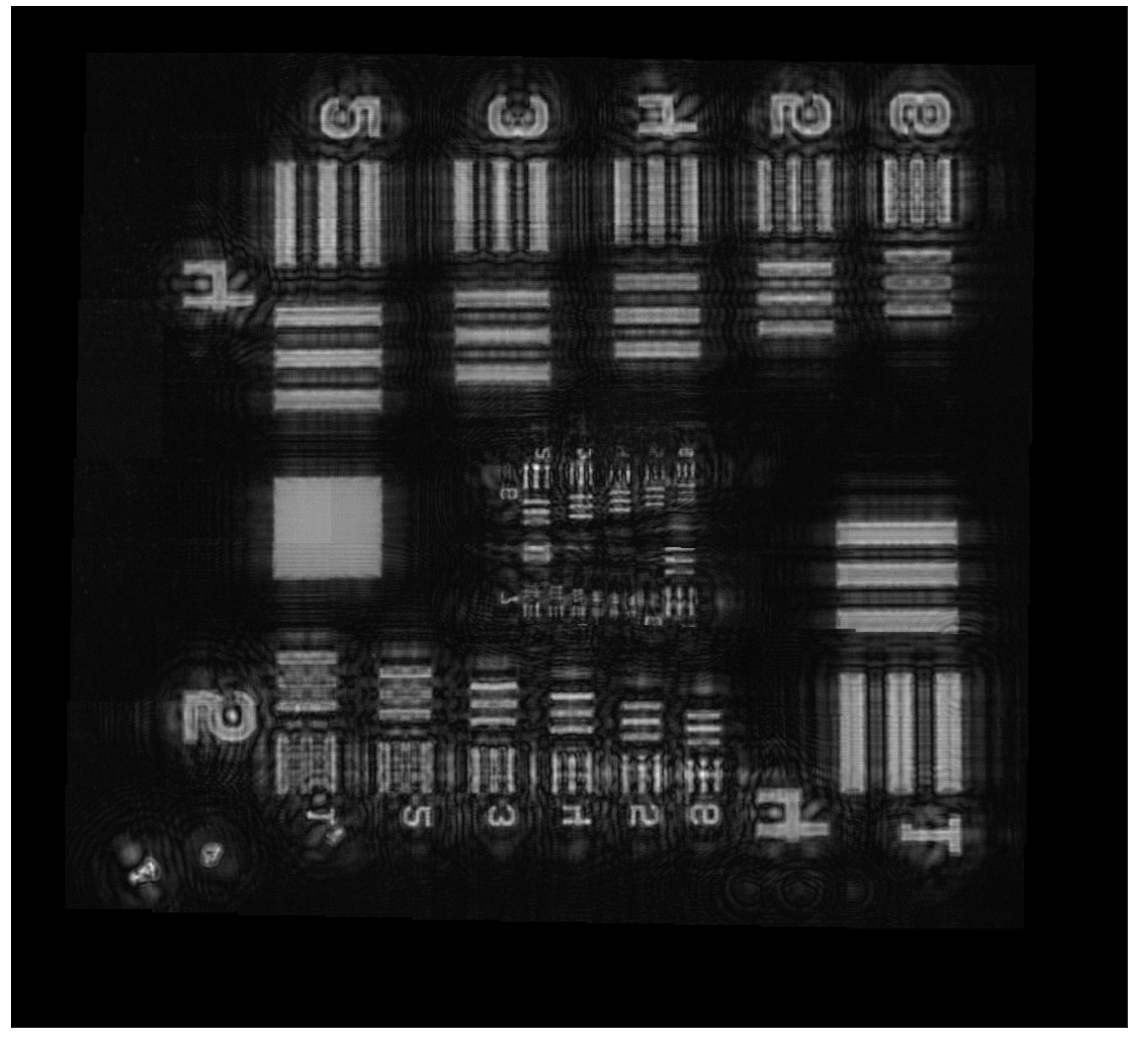

In [43]:
factReduce = 4
factAugment = 1
wiggle = 5
stack = False
recalculate = False
cut = False
holosHechosCuttet = [im[90:im.shape[0]-90, 160:im.shape[1]-160] for im in holosHechos]
imagesRec = [skimage.transform.rescale(im, 1 / factReduce, anti_aliasing=True) for im in holosHechosCuttet]
modelX, modelY = totalMedDistanceVectorTest(imagesRec, 10, 10)
mos = mosaicModel(holosHechosCuttet, 10, 10,
                    ddx=modelX.intercept_*factReduce, dddx_dx=modelX.coef_[1] * factReduce, dddx_dy=modelX.coef_[0] * factReduce,
                    ddy=modelY.intercept_*factReduce, dddy_dx=modelY.coef_[1] * factReduce, dddy_dy=modelY.coef_[0] * factReduce,
                    vis=False, wiggle=wiggle, stack=stack, factAugment=factAugment, recalculate=recalculate, cut=cut)
mos = mos - mos.min()
vis1(mos)


In [15]:
def recAutomaticModel2(ims, nx, ny, lamb=530e-9, separation_pixels_camera=6e-6, z=0.01, z0=0.001078, apodization=100, factReduce=4, factAugment=1, wiggle=0, stack=True, vis=False, verbose=False, recalculate=False, sureAltura=False, cut=False):

    n = ims[0].shape[0]
    if verbose: print("Reconstructing individual images...")

    imagesRec = [skimage.transform.rescale(im, 1 / factReduce, anti_aliasing=True) for im in ims]

    

    if verbose: print("Calculating offset...")
    modelX, modelY = totalMedDistanceVectorTest(imagesRec, nx, ny)

    imagesRec = [reconstructHologramSph(im,lamb=lamb,h=n*separation_pixels_camera, z=z, z0=z0, vis=True) for im in ims]

    if verbose: print("Creating mosaic with original images...")
    mos = mosaicModel(imagesRec, nx, ny,
                      ddx=modelX.intercept_*factReduce, dddx_dx=modelX.coef_[1] * factReduce, dddx_dy=modelX.coef_[0] * factReduce,
                      ddy=modelY.intercept_*factReduce, dddy_dx=modelY.coef_[1] * factReduce, dddy_dy=modelY.coef_[0] * factReduce,
                      vis=vis, wiggle=wiggle, stack=stack, factAugment=factAugment, recalculate=recalculate, cut=cut)
    mos = mos - mos.min()

    if apodization > 0:
        if verbose: print("Apodization filter...")
        mos = apodize(mos, apodization)
        if vis: vis1(mos)

    if verbose: print("Done.")

    return mos, rec

In [19]:
cuadrao = [reconstructHologramSph(holos[i],lamb=530e-9,h=holos[45].shape[0]*6e-6, z=0.01, z0=0.001078, vis=True) for i in (34,35,36,44,45,46,54,55,56)]

aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui


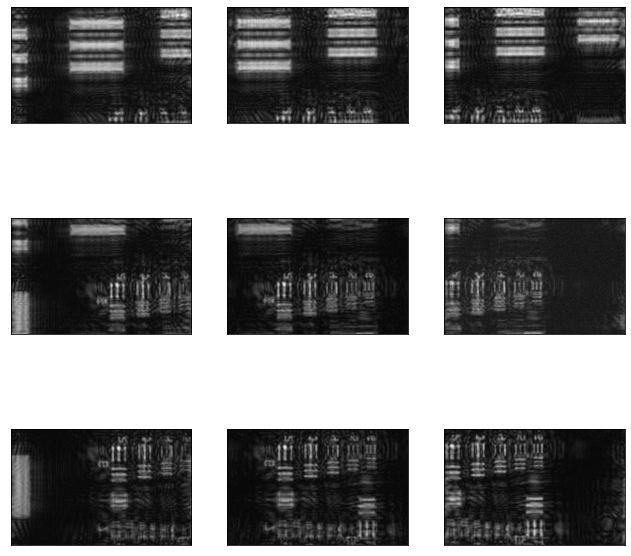

In [20]:
visualizeN(cuadrao, 3,3)

aqui


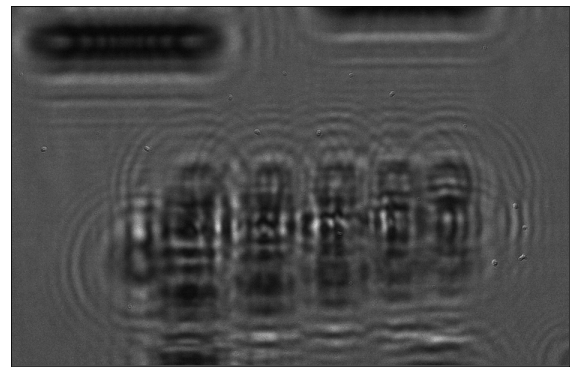

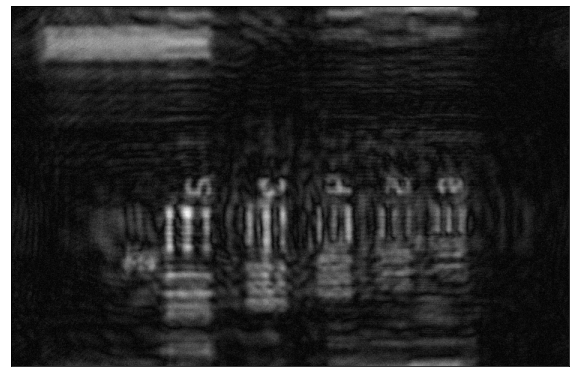

In [18]:
a = reconstructHologramSph(holos[45],lamb=530e-9,h=holos[45].shape[0]*6e-6, z=0.01, z0=0.001078, vis=True)
vis1(holos[45],figSize=(10,10))
vis1(a,figSize=(10,10))

435
1173


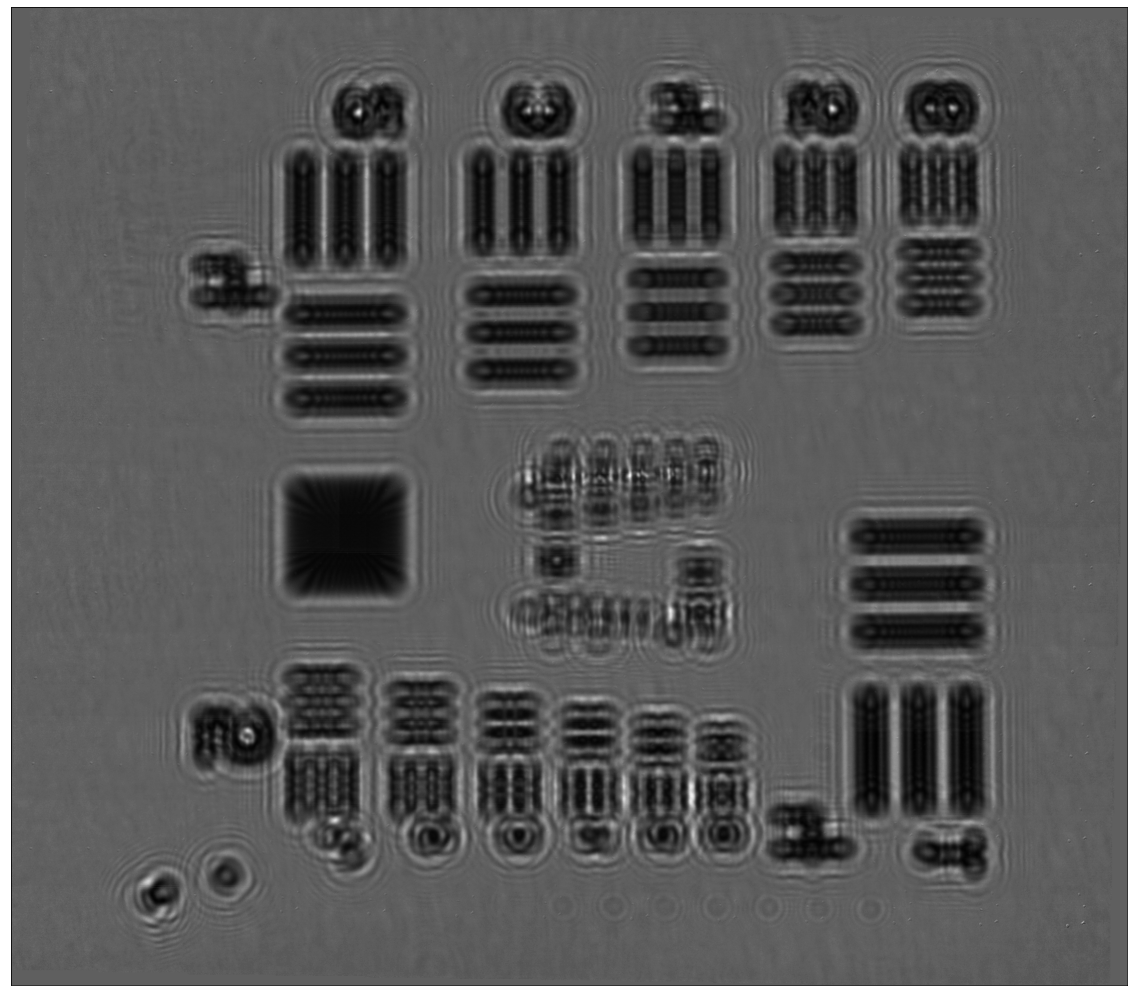

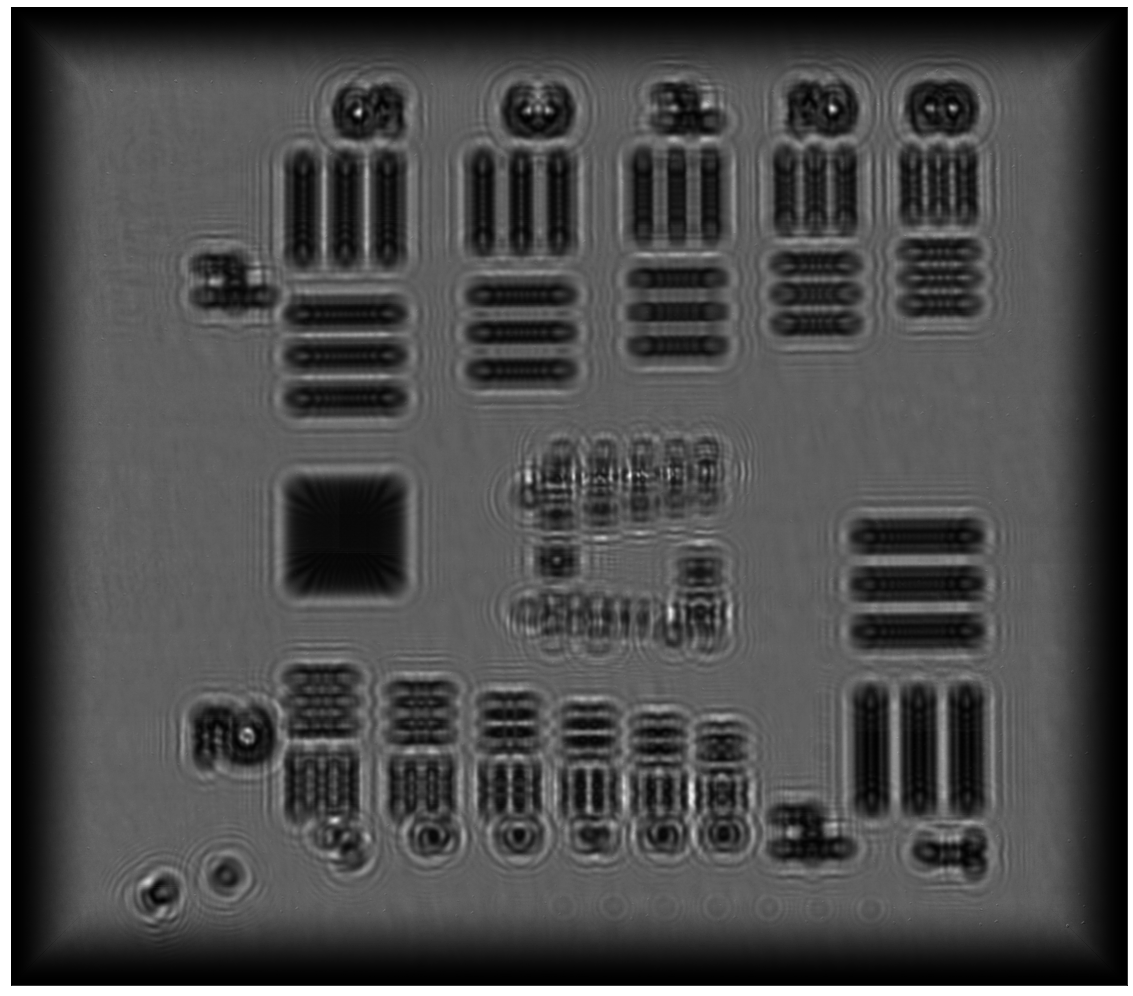

aqui


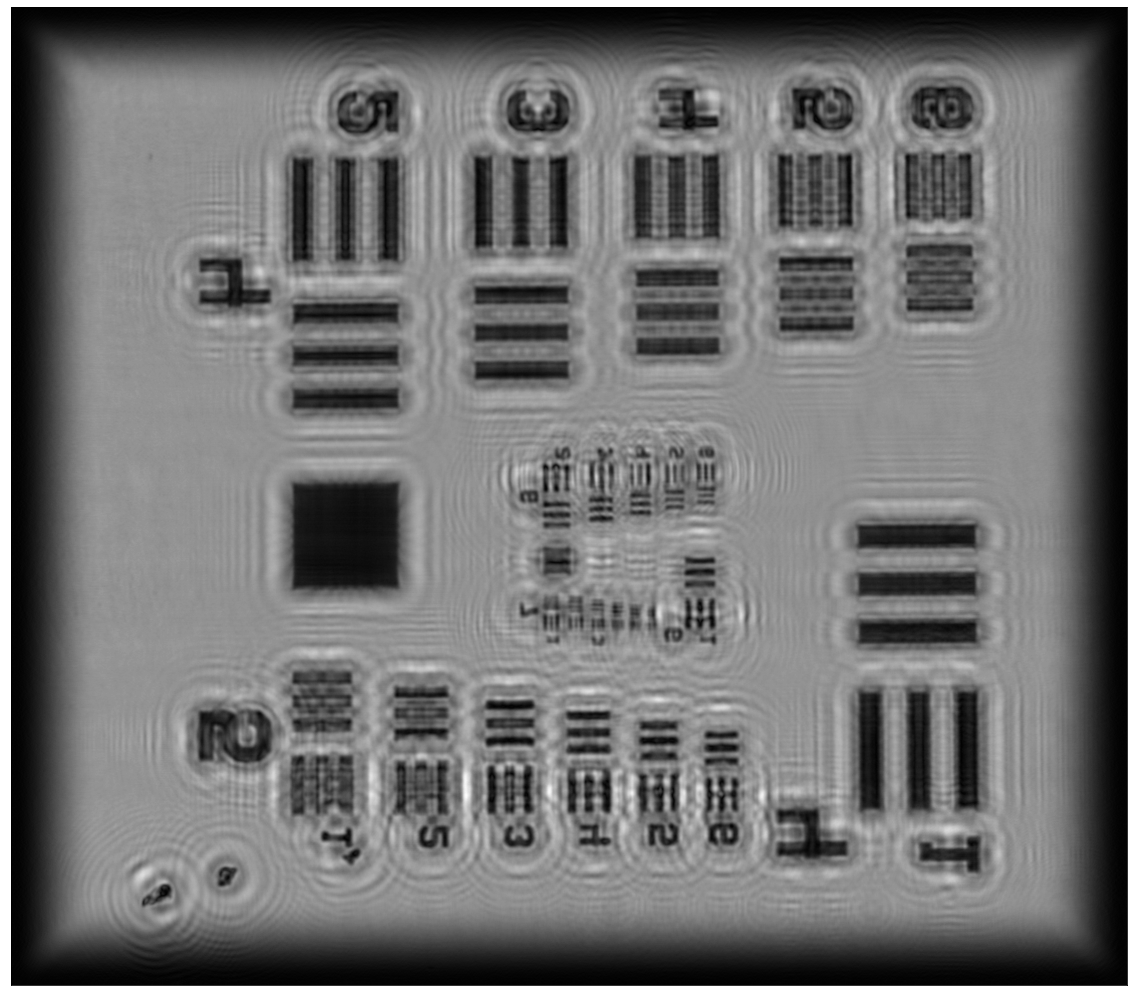

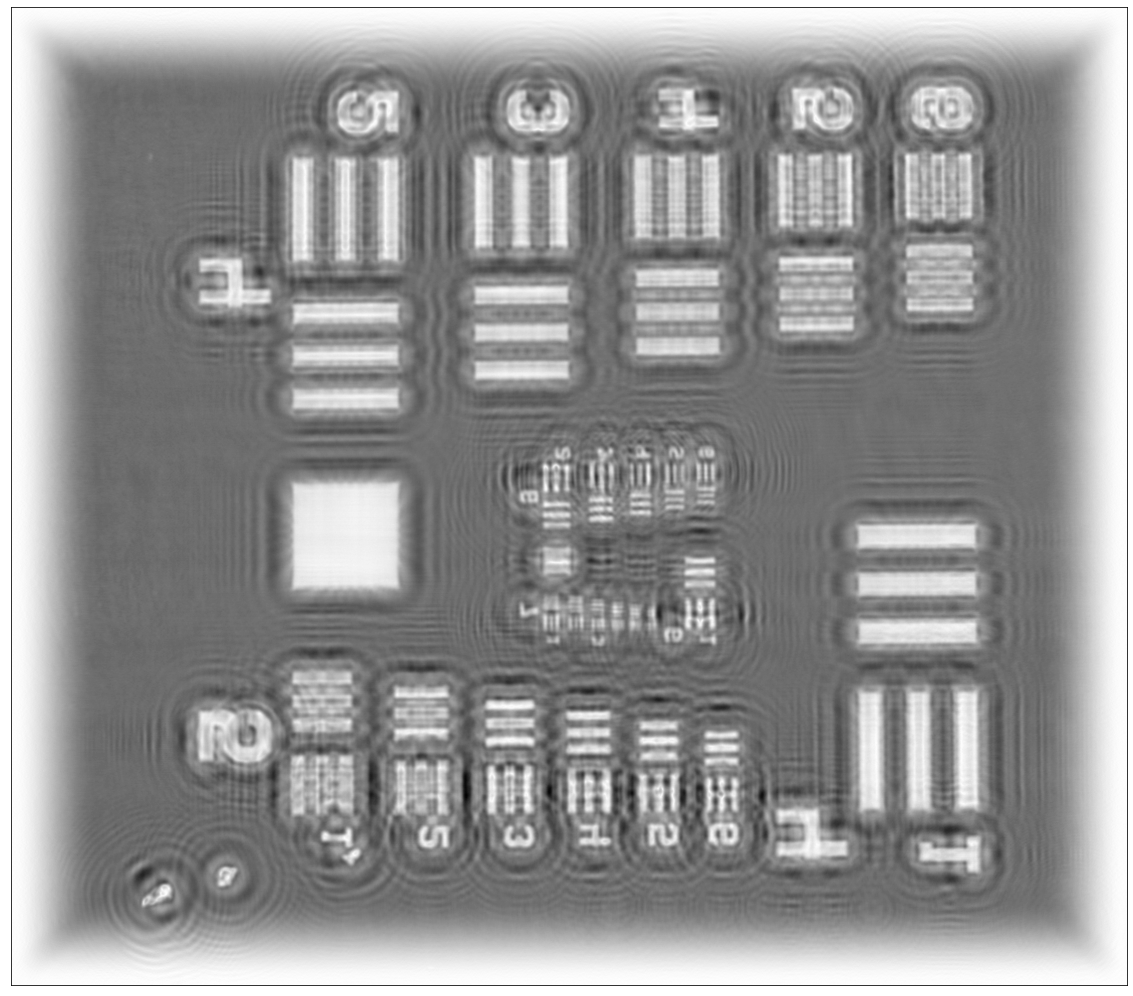

In [42]:
mos_gran, rec_gran = recAutomaticModel(holos, 10, 10, wiggle=5, factAugment=1, stack=True, vis=True, verbose=False, cut=True,sureAltura=False, recalculate=False, apodization=200)

Reconstructing individual images...
Calculating offset...
435
1173
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
aqui
Creating mosaic with original images...


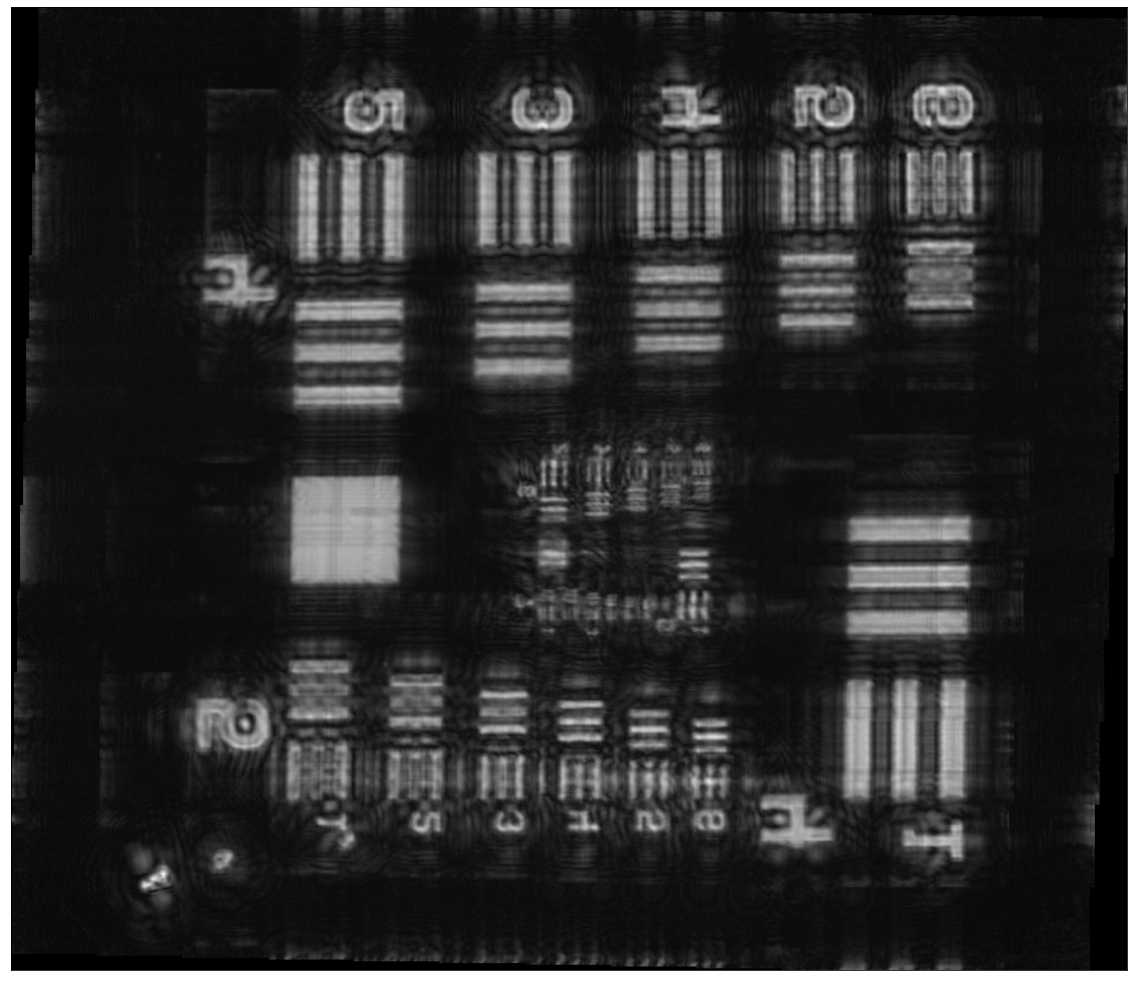

Apodization filter...


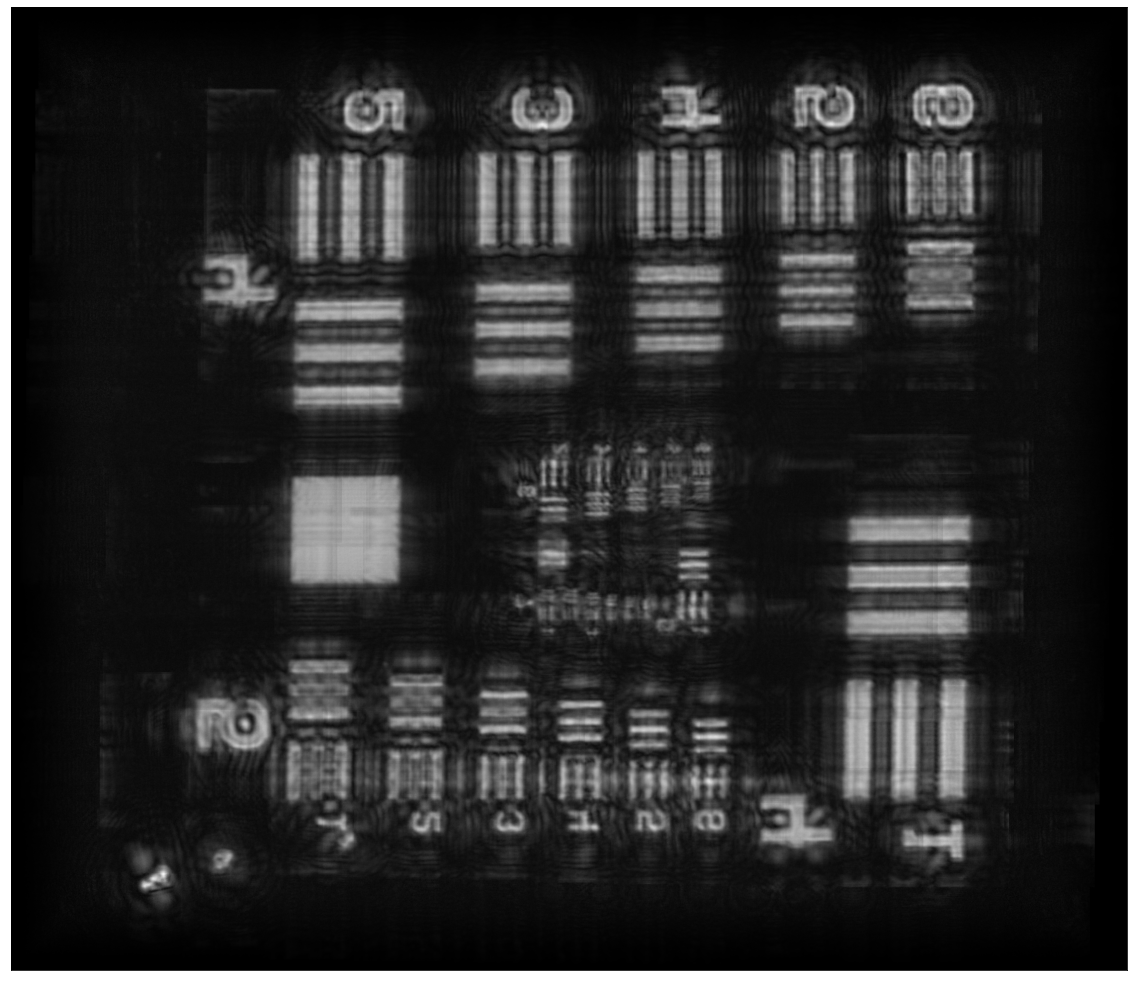

Done.


NameError: name 'rec' is not defined

In [27]:
mos_gran, rec_gran = recAutomaticModel2(holos, 10, 10, wiggle=1, factAugment=1, stack=True, vis=True, verbose=True, cut=True, recalculate=False, apodization=200)